# Grayscale
<a target="_blank" href="https://colab.research.google.com/github/Tcc0403/gpu-100-days/blob/main/day003/grayscale.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [30]:
!nvidia-smi

Fri Feb 13 18:14:34 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             31W /   70W |    8925MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Setup

In [31]:
import torch
import triton
import triton.language as tl
import matplotlib.pyplot as plt
from torchvision import io

In [32]:
DEVICE = 'cuda'

In [33]:
!mkdir "img"
!mkdir "benchmark"

mkdir: cannot create directory ‘img’: File exists


In [34]:
import cv2
!wget "https://raw.githubusercontent.com/Tcc0403/gpu-100-days/refs/heads/main/day003/img/img0.jpg"
!mv "img0.jpg" "img/img0.jpg"
img0 = io.decode_image('img/img0.jpg').cuda()
print(img0.shape)


--2026-02-13 18:14:35--  https://raw.githubusercontent.com/Tcc0403/gpu-100-days/refs/heads/main/day003/img/img0.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 183778 (179K) [image/jpeg]
Saving to: ‘img0.jpg’

img0.jpg            100%[===================>] 179.47K  --.-KB/s    in 0.02s   

2026-02-13 18:14:35 (9.93 MB/s) - ‘img0.jpg’ saved [183778/183778]

torch.Size([3, 785, 776])


In [35]:
def show_img(x, figsize=(8,6), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

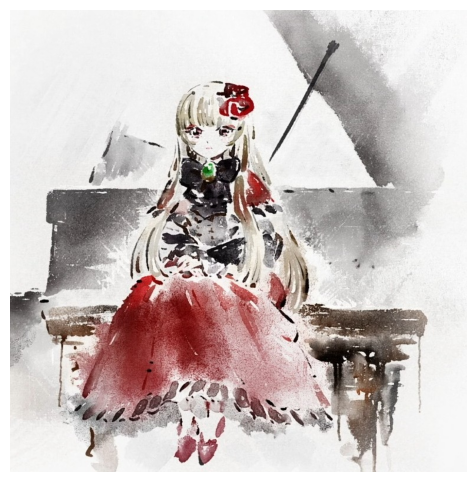

In [36]:
show_img(img0)

## Write a reference kernel as baseline

In [37]:
def ref_grayscale(x):
    c,h,w = x.shape
    R = x[0, :, :]
    G = x[1, :, :]
    B = x[2, :, :]

    res = 0.2989 * R + 0.5870 * G + 0.1140 * B
    return res.view(h,w)

In [38]:
img0_gray = ref_grayscale(img0)

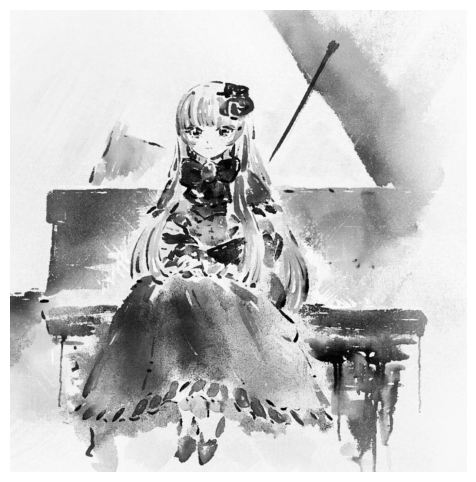

In [39]:
show_img(img0_gray, cmap="gray")

## Write Triton kernel

In [40]:
@triton.jit
def grayscale_element_kernel(
    x_ptr,
    output_ptr,
    n_elements, # H * W
    BLOCK_SIZE: tl.constexpr
):
    pid = tl.program_id(0)

    r_ptr_start = x_ptr
    g_ptr_start = x_ptr + n_elements
    b_ptr_start = x_ptr + 2 * n_elements

    block_offset = BLOCK_SIZE * pid
    r_block_start = r_ptr_start + block_offset
    g_block_start = g_ptr_start + block_offset
    b_block_start = b_ptr_start + block_offset

    output_ptr = output_ptr + BLOCK_SIZE * pid

    offsets = tl.arange(0, BLOCK_SIZE)
    r_ptrs = r_block_start + offsets
    g_ptrs = g_block_start + offsets
    b_ptrs = b_block_start + offsets

    mask = block_offset + offsets < n_elements
    r = tl.load(r_ptrs, mask=mask)
    g = tl.load(g_ptrs, mask=mask)
    b = tl.load(b_ptrs, mask=mask)

    output = 0.2989 * r + 0.5870 * g + 0.1140 * b
    tl.store(output_ptr + offsets, output, mask=mask)

## Helper function to allocate tensors

In [41]:
def grayscale_element(x):
    C, H, W = x.shape
    output = torch.empty((H, W), dtype=x.dtype, device=x.device)
    n_elements = H * W
    BLOCK_SIZE = 1024

    grid = (triton.cdiv(x.numel(), BLOCK_SIZE),)
    grayscale_element_kernel[grid](x, output, n_elements, BLOCK_SIZE=BLOCK_SIZE)

    return output


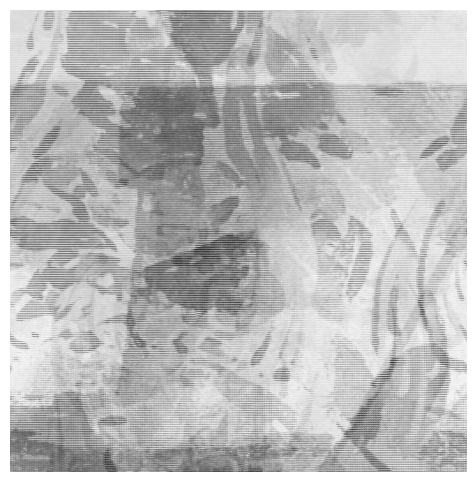

In [42]:
img0_gray_v0 = grayscale_element(img0)
show_img(img0_gray_v0, cmap="gray")

### Why incorrect?  **Contiguous!**

https://ezyang.github.io/stride-visualizer/index.html

https://blog.ezyang.com/2019/05/pytorch-internals/

In [43]:
print(img0.shape)
print(img0.stride())

torch.Size([3, 785, 776])
(1, 2328, 3)


In [44]:
print(img0.contiguous().stride())

(609160, 776, 1)


In [45]:
def grayscale_element_ensure_contiguous(x):
    C, H, W = x.shape
    output = torch.empty((H, W), dtype=x.dtype, device=x.device)
    n_elements = H * W
    BLOCK_SIZE = 1024

    # Ensure Contiguous
    x = x.contiguous()

    # grid = (triton.cdiv(x.numel(), BLOCK_SIZE),)
    grid = lambda meta: (triton.cdiv(x.numel(), meta['BLOCK_SIZE']), )
    grayscale_element_kernel[grid](x, output, n_elements, BLOCK_SIZE)

    return output

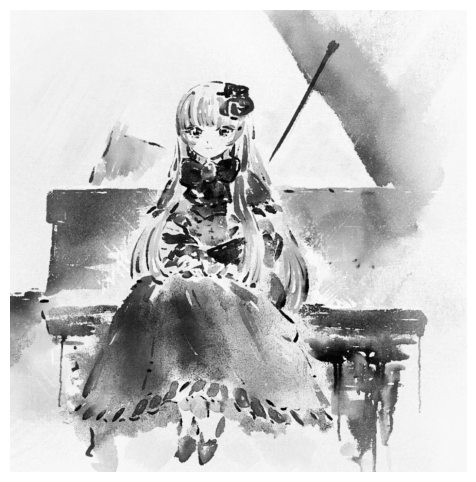

In [46]:
img0_gray_v1 = grayscale_element_ensure_contiguous(img0)
show_img(img0_gray_v1, cmap="gray")

## Another Triton Kernel


In [47]:
@triton.jit
def grayscale_2d_kernel(
    x_ptr,
    output_ptr,
    h,
    w,
    BLOCK_H: tl.constexpr,
    BLOCK_W: tl.constexpr,
):
    pid_h = tl.program_id(0)
    pid_w = tl.program_id(1)

    r_ptr_start = x_ptr
    g_ptr_start = x_ptr + h * w
    b_ptr_start = x_ptr + 2 * h * w

    # Calculate offsets
    offsets_h = pid_h * BLOCK_H + tl.arange(0, BLOCK_H)  # 1d
    offsets_w = pid_w * BLOCK_W + tl.arange(0, BLOCK_W)  # 1d

    block_offsets = w * offsets_h[:, None] + offsets_w[None, :]  # 2d

    r_ptrs = r_ptr_start + block_offsets
    g_ptrs = g_ptr_start + block_offsets
    b_ptrs = b_ptr_start + block_offsets


    # Calculate mask
    mask_h = offsets_h < h   # 1d
    mask_w = offsets_w < w   # 1d
    mask = mask_h[:, None] & mask_w[None, :]  # 2d




    r = tl.load(r_ptrs, mask=mask)
    g = tl.load(g_ptrs, mask=mask)
    b = tl.load(b_ptrs, mask=mask)

    output = 0.2989 * r + 0.5870 * g + 0.1140 * b
    tl.store(output_ptr + block_offsets, output, mask=mask)

In [48]:
def grayscale_2d_ensure_contiguous(x):
    C, H, W = x.shape
    output = torch.empty((H, W), dtype=x.dtype, device=x.device)
    BLOCK_H = 32
    BLOCK_W = 32

    # Ensure Contiguous
    x = x.contiguous()

    # grid = (triton.cdiv(H, BLOCK_H), triton.cdiv(W, BLOCK_W))
    grid = lambda meta: (triton.cdiv(H, meta['BLOCK_H']), triton.cdiv(W, meta['BLOCK_W']))
    grayscale_2d_kernel[grid](x, output, H, W, BLOCK_H, BLOCK_W)

    return output

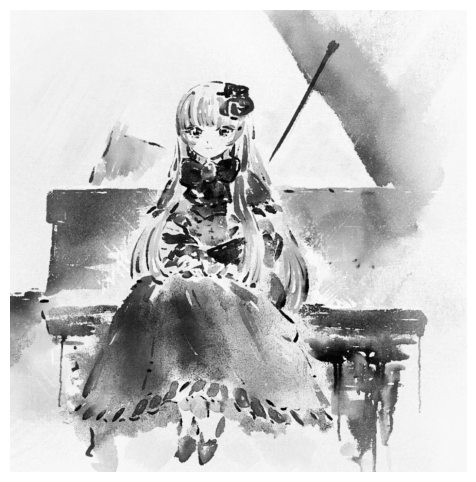

In [49]:
img0_gray_v2 = grayscale_2d_ensure_contiguous(img0)
show_img(img0_gray_v2, cmap="gray")

## Congrats! Try more images!

--2026-02-13 18:14:36--  https://raw.githubusercontent.com/Tcc0403/gpu-100-days/refs/heads/main/day003/img/img1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182738 (178K) [image/jpeg]
Saving to: ‘img1.jpg’

img1.jpg            100%[===================>] 178.46K  --.-KB/s    in 0.01s   

2026-02-13 18:14:36 (11.7 MB/s) - ‘img1.jpg’ saved [182738/182738]



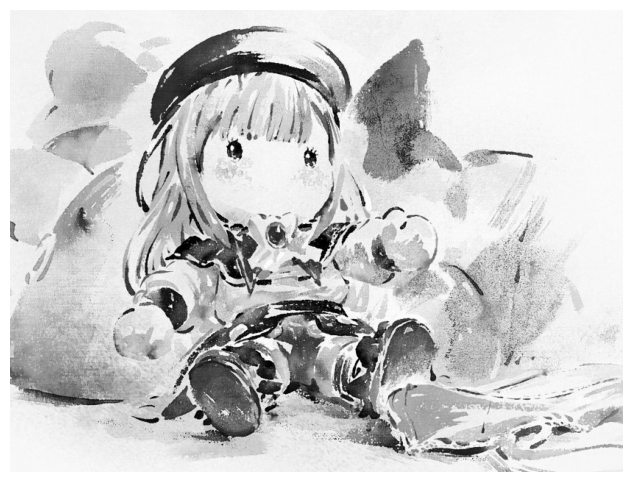

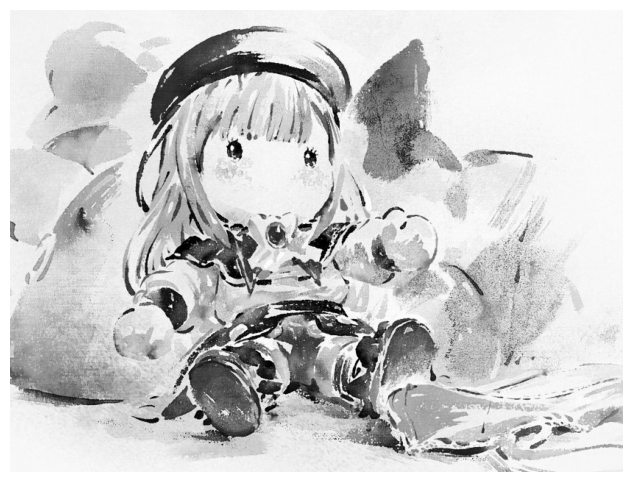

In [50]:
!wget "https://raw.githubusercontent.com/Tcc0403/gpu-100-days/refs/heads/main/day003/img/img1.jpg"
!mv "img1.jpg" "img/img1.jpg"
img1 = io.decode_image('img/img1.jpg').cuda()
img1_gray_v1 = grayscale_element_ensure_contiguous(img1)
img1_gray_v2 = grayscale_2d_ensure_contiguous(img1)

show_img(img1_gray_v1, cmap="gray")
show_img(img1_gray_v2, cmap="gray")

--2026-02-13 18:14:37--  https://raw.githubusercontent.com/Tcc0403/gpu-100-days/refs/heads/main/day003/img/img2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106421 (104K) [image/jpeg]
Saving to: ‘img2.jpg’

img2.jpg            100%[===================>] 103.93K  --.-KB/s    in 0.008s  

2026-02-13 18:14:37 (12.2 MB/s) - ‘img2.jpg’ saved [106421/106421]



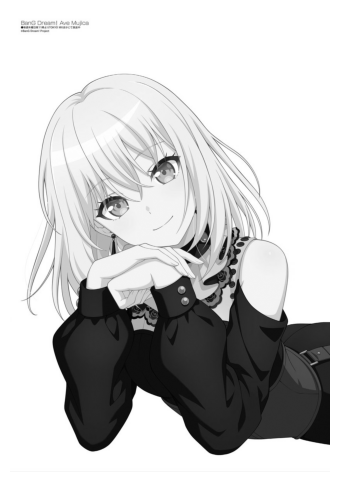

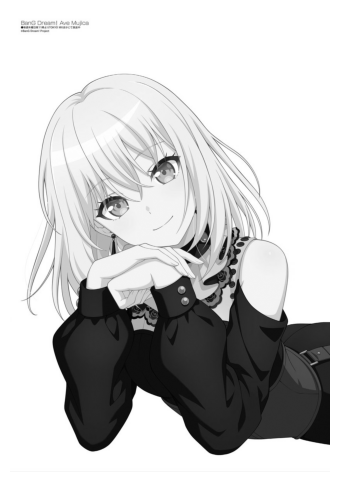

In [51]:
!wget "https://raw.githubusercontent.com/Tcc0403/gpu-100-days/refs/heads/main/day003/img/img2.jpg"
!mv "img2.jpg" "img/img2.jpg"
img2 = io.decode_image('img/img2.jpg').cuda()
img2_gray_v1 = grayscale_element_ensure_contiguous(img2)
img2_gray_v2 = grayscale_2d_ensure_contiguous(img2)

show_img(img2_gray_v1, cmap="gray")
show_img(img2_gray_v2, cmap="gray")

## Test the correctness

In [52]:
def test_1d(C, H, W, with_transpose=False):

    size = (C, H, W) if not with_transpose else (H, W, C)

    x = torch.randn(size, device=DEVICE)

    if with_transpose:
        x = x.permute(2, 0, 1)  # H, W, C -> C, H, W

    output_ref = ref_grayscale(x)
    output_triton = grayscale_element_ensure_contiguous(x)

    torch.testing.assert_close(output_triton, output_ref)
    print("✅ Triton kernel is correct!")

C, H, W = 3, 2025, 4096
test_1d(C, H, W)
test_1d(C, H, W, with_transpose=True)

✅ Triton kernel is correct!
✅ Triton kernel is correct!


In [53]:
def test_2d(C, H, W, with_transpose=False):

    size = (C, H, W) if not with_transpose else (H, W, C)

    x = torch.randn(size, device=DEVICE)

    if with_transpose:
        x = x.permute(2, 0, 1)  # H, W, C -> C, H, W

    output_ref = ref_grayscale(x)
    output_triton = grayscale_2d_ensure_contiguous(x)

    torch.testing.assert_close(output_triton, output_ref)
    print("✅ Triton kernel is correct!")


C, H, W = 3, 2025, 4096
test_2d(C, H, W)
test_2d(C, H, W, with_transpose=True)

✅ Triton kernel is correct!
✅ Triton kernel is correct!


## Benchmark with `triton.testing.do_bench`

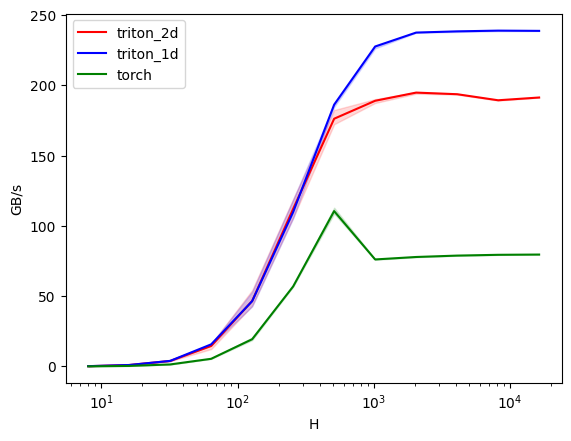

grayscale-performance:
          H   triton_2d   triton_1d       torch
0       8.0    0.150943    0.184971    0.063872
1      16.0    1.000000    1.000000    0.347826
2      32.0    3.878788    3.938462    1.398907
3      64.0   14.524823   15.693487    5.417989
4     128.0   46.545454   46.413598   19.343566
5     256.0  112.027350  109.775543   56.888887
6     512.0  176.172039  186.181817  110.469452
7    1024.0  188.932617  227.555548   76.077487
8    2048.0  194.757800  237.449270   77.830839
9    4096.0  193.607097  238.312729   78.816598
10   8192.0  189.298745  238.836890   79.379036
11  16384.0  191.260911  238.665311   79.555669


<Figure size 640x480 with 0 Axes>

In [54]:
import os

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['H'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2 ** i for i in range(3, 15, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton_2d', 'triton_1d', 'torch'],  # Possible values for `line_arg`.
        line_names=['triton_2d', 'triton_1d', 'torch'],  # Possible values for `line_arg`.
        styles=[('red', '-'), ('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='grayscale-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark_gbps(H, provider):


    W = H
    size = (C, H, W)

    x = torch.randn(size, device=DEVICE)


    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ref_grayscale(x), quantiles=quantiles)
    if provider == 'triton_1d':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: grayscale_element_ensure_contiguous(x), quantiles=quantiles)
    if provider == 'triton_2d':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: grayscale_2d_ensure_contiguous(x), quantiles=quantiles)
    gbps = lambda ms: 4 * H * W * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark_gbps.run(print_data=True, show_plots=True, save_path=os.path.abspath("../benchmark"))

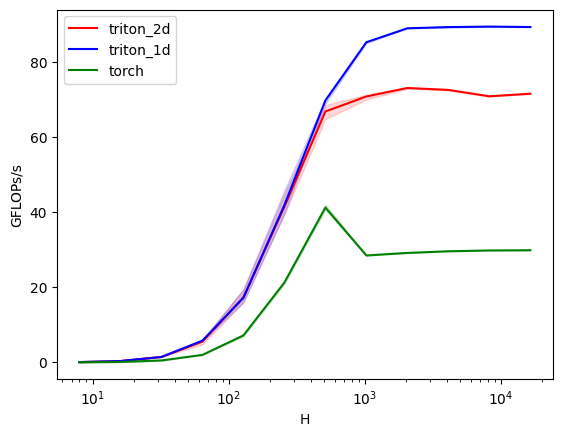

grayscale-performance:
          H  triton_2d  triton_1d      torch
0       8.0   0.093023   0.093750   0.033566
1      16.0   0.375000   0.375000   0.129730
2      32.0   1.465649   1.460076   0.524590
3      64.0   5.545126   5.818182   2.010471
4     128.0  17.355933  17.210084   7.194380
5     256.0  41.513512  41.938566  21.296359
6     512.0  66.873469  69.818181  41.269522
7    1024.0  70.875272  85.333330  28.506307
8    2048.0  73.142858  89.043476  29.187648
9    4096.0  72.622774  89.367273  29.622185
10   8192.0  70.926209  89.492482  29.838114
11  16384.0  71.612119  89.382825  29.901220


<Figure size 640x480 with 0 Axes>

In [55]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['H'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2 ** i for i in range(3, 15, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton_2d', 'triton_1d', 'torch'],  # Possible values for `line_arg`.
        line_names=['triton_2d', 'triton_1d', 'torch'],  # Possible values for `line_arg`.
        styles=[('red', '-'), ('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GFLOPs/s',  # Label name for the y-axis.
        plot_name='grayscale-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark_gflops(H, provider):


    W = H
    size = (C, H, W)

    x = torch.randn(size, device=DEVICE)


    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ref_grayscale(x), quantiles=quantiles)
    if provider == 'triton_1d':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: grayscale_element_ensure_contiguous(x), quantiles=quantiles)
    if provider == 'triton_2d':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: grayscale_2d_ensure_contiguous(x), quantiles=quantiles)
    # 3 mulitplication and 3 addition
    gflops = lambda ms: 6 * H * W * 1e-9 / (ms * 1e-3)
    return gflops(ms), gflops(max_ms), gflops(min_ms)


benchmark_gflops.run(print_data=True, show_plots=True, save_path=os.path.abspath("../benchmark"))

## Autotune


In [56]:
@triton.autotune(
        configs=[
            triton.Config({'BLOCK_H': 32, 'BLOCK_W': 32}, num_warps=2),
            triton.Config({'BLOCK_H': 64, 'BLOCK_W': 32}, num_warps=2),
            triton.Config({'BLOCK_H': 32, 'BLOCK_W': 64}, num_warps=4),
            triton.Config({'BLOCK_H': 64, 'BLOCK_W': 64}, num_warps=4),
            triton.Config({'BLOCK_H': 128, 'BLOCK_W': 64}, num_warps=8),
            triton.Config({'BLOCK_H': 64, 'BLOCK_W': 128}, num_warps=8),
            triton.Config({'BLOCK_H': 128, 'BLOCK_W': 128}, num_warps=8),
        ],
        key=['h', 'w']
)
@triton.jit
def grayscale_2d_autotuned_kernel(
    x_ptr,
    output_ptr,
    h,
    w,
    BLOCK_H: tl.constexpr,
    BLOCK_W: tl.constexpr,
):
    pid_h = tl.program_id(0)
    pid_w = tl.program_id(1)

    r_ptr_start = x_ptr
    g_ptr_start = x_ptr + h * w
    b_ptr_start = x_ptr + 2 * h * w

    # Calculate offsets
    offsets_h = pid_h * BLOCK_H + tl.arange(0, BLOCK_H)  # 1d
    offsets_w = pid_w * BLOCK_W + tl.arange(0, BLOCK_W)  # 1d

    block_offsets = w * offsets_h[:, None] + offsets_w[None, :]  # 2d

    r_ptrs = r_ptr_start + block_offsets
    g_ptrs = g_ptr_start + block_offsets
    b_ptrs = b_ptr_start + block_offsets


    # Calculate mask
    mask_h = offsets_h < h   # 1d
    mask_w = offsets_w < w   # 1d
    mask = mask_h[:, None] & mask_w[None, :]  # 2d




    r = tl.load(r_ptrs, mask=mask)
    g = tl.load(g_ptrs, mask=mask)
    b = tl.load(b_ptrs, mask=mask)

    output = 0.2989 * r + 0.5870 * g + 0.1140 * b
    tl.store(output_ptr + block_offsets, output, mask=mask)


def grayscale_2d_autotuned(x):
    C, H, W = x.shape
    output = torch.empty((H, W), dtype=x.dtype, device=x.device)
    # BLOCK_H = 32
    # BLOCK_W = 32

    # Ensure Contiguous
    x = x.contiguous()

    # grid = (triton.cdiv(H, BLOCK_H), triton.cdiv(W, BLOCK_W))
    grid = lambda meta: (triton.cdiv(H, meta['BLOCK_H']), triton.cdiv(W, meta['BLOCK_W']))
    grayscale_2d_autotuned_kernel[grid](x, output, H, W)

    return output

`TRITON_PRINT_AUTOTUNING=1` prints out the best autotuning config and total time spent for each kernel after autotuning is complete.

`TRITON_ALWAYS_COMPILE=1` forces to compile kernels regardless of cache hit.

In [57]:
# TRITON_PRINT_AUTOTUNING=1
# TRITON_ALWAYS_COMPILE=1

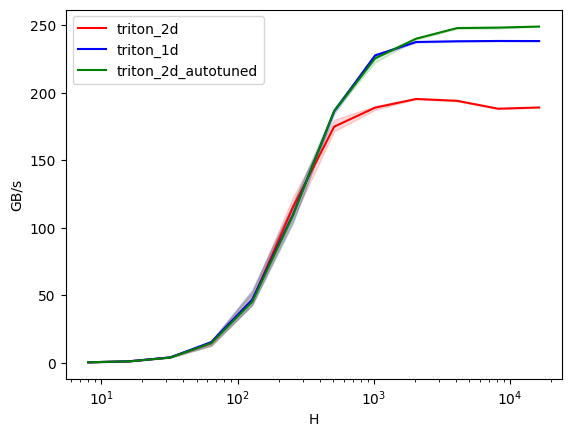

grayscale-performance:
          H   triton_2d   triton_1d  triton_2d_autotuned
0       8.0    0.249027    0.250000             0.243346
1      16.0    1.000000    0.992248             0.966038
2      32.0    3.835206    3.878788             3.737226
3      64.0   14.371930   15.170371            14.422535
4     128.0   45.893558   46.545454            45.010988
5     256.0  115.380278  109.959732           109.409011
6     512.0  174.762665  186.181817           186.181817
7    1024.0  188.830545  227.555548           225.306401
8    2048.0  195.247369  237.449270           239.893846
9    4096.0  193.893484  237.981456           247.754859
10   8192.0  188.040584  238.204453           248.118513
11  16384.0  188.967593  238.150339           248.878105


<Figure size 640x480 with 0 Axes>

In [58]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['H'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2 ** i for i in range(3, 15, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton_2d', 'triton_1d', 'triton_2d_autotuned'],  # Possible values for `line_arg`.
        line_names=['triton_2d', 'triton_1d', 'triton_2d_autotuned'],  # Possible values for `line_arg`.
        styles=[('red', '-'), ('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='grayscale-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(H, provider):


    W = H
    size = (C, H, W)

    x = torch.randn(size, device=DEVICE)


    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'triton_1d':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: grayscale_element_ensure_contiguous(x), quantiles=quantiles)
    if provider == 'triton_2d':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: grayscale_2d_ensure_contiguous(x), quantiles=quantiles)
    if provider == 'triton_2d_autotuned':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: grayscale_2d_autotuned(x), quantiles=quantiles)
    gbps = lambda ms: 4 * H * W * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True, save_path=os.path.abspath("../benchmark"))